# はじめに

In [3]:
var userHomeDir = System.getProperty("user.home");
var localRespoUrl = "file://" + userHomeDir + "/.m2/repository/";
var langchain4jVersion = "1.0.1";
var langchain4jbeta = "1.0.1-beta6";
var langgraph4jVersion = "1.6.0-beta2";

Jupyterキャッシュからインストールされたパッケージを削除

In [4]:
%%bash 
rm -rf \{userHomeDir}/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/bsc/langgraph4j

ローカルMavenリポジトリを追加し、必要なMaven依存関係をインストール

In [5]:
%dependency /add-repo local \{localRespoUrl} release|never snapshot|always
// %dependency /list-repos
%dependency /add org.slf4j:slf4j-jdk14:2.0.9
%dependency /add org.bsc.langgraph4j:langgraph4j-core:\{langgraph4jVersion}
%dependency /add net.sourceforge.plantuml:plantuml-mit:1.2024.8
%dependency /resolve

Repository local url: file:///Users/koheisaito/.m2/repository/ added.
Adding dependency org.slf4j:slf4j-jdk14:2.0.9
Adding dependency org.bsc.langgraph4j:langgraph4j-core:1.6.0-beta2
Adding dependency net.sourceforge.plantuml:plantuml-mit:1.2024.8
Solving dependencies
Resolved artifacts count: 5
Add to classpath: /Users/koheisaito/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/slf4j/slf4j-jdk14/2.0.9/slf4j-jdk14-2.0.9.jar
Add to classpath: /Users/koheisaito/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/slf4j/slf4j-api/2.0.9/slf4j-api-2.0.9.jar
Add to classpath: /Users/koheisaito/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/bsc/langgraph4j/langgraph4j-core/1.6.0-beta2/langgraph4j-core-1.6.0-beta2.jar
Add to classpath: /Users/koheisaito/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/bsc/async/async-generator/3.2.0/async-generator-3.2.0.jar
Add to classpath: /Users/koheisaito/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cach

In [6]:
import net.sourceforge.plantuml.SourceStringReader;
import net.sourceforge.plantuml.FileFormatOption;
import net.sourceforge.plantuml.FileFormat;
import org.bsc.langgraph4j.GraphRepresentation;

void displayDiagram( GraphRepresentation representation ) throws IOException { 
    
    var reader = new SourceStringReader(representation.getContent());

    try(var imageOutStream = new java.io.ByteArrayOutputStream()) {

        var description = reader.outputImage( imageOutStream, 0, new FileFormatOption(FileFormat.PNG));

        var imageInStream = new java.io.ByteArrayInputStream(  imageOutStream.toByteArray() );

        var image = javax.imageio.ImageIO.read( imageInStream );

        display(  image );

    }
}

## 1. Stateの定義

- State: **メッセージのリストを保持**します。

In [7]:
import org.bsc.langgraph4j.state.AgentState;
import org.bsc.langgraph4j.state.Channels;
import org.bsc.langgraph4j.state.Channel;

import java.util.Collections;
import java.util.List;
import java.util.Map;
import java.util.Optional;

// Define the state for our graph
class SimpleState extends AgentState {
    public static final String MESSAGES_KEY = "messages";

    // Define the schema for the state.
    // MESSAGES_KEY will hold a list of strings, and new messages will be appended.
    public static final Map<String, Channel<?>> SCHEMA = Map.of(
            MESSAGES_KEY, Channels.appender(ArrayList::new)
    );

    public SimpleState(Map<String, Object> initData) {
        super(initData);
    }

    public List<String> messages() {
        return this.<List<String>>value("messages")
                .orElse( List.of() );
    }
}

## 2. ノードの定義

In [8]:
import org.bsc.langgraph4j.action.NodeAction;
import java.util.Collections;
import java.util.Map;

// Node that adds a greeting
class GreeterNode implements NodeAction<SimpleState> {
    @Override
    public Map<String, Object> apply(SimpleState state) {
        System.out.println("GreeterNode executing. Current messages: " + state.messages());
        return Map.of(SimpleState.MESSAGES_KEY, "Hello from GreeterNode!");
    }
}

// Node that adds a response
class ResponderNode implements NodeAction<SimpleState> {
    @Override
    public Map<String, Object> apply(SimpleState state) {
        System.out.println("ResponderNode executing. Current messages: " + state.messages());
        List<String> currentMessages = state.messages();
        if (currentMessages.contains("Hello from GreeterNode!")) {
            return Map.of(SimpleState.MESSAGES_KEY, "Acknowledged greeting!");
        }
        return Map.of(SimpleState.MESSAGES_KEY, "No greeting found.");
    }
}

## 3. グラフの定義とコンパイル

In [ ]:
import org.bsc.langgraph4j.StateGraph;
import org.bsc.langgraph4j.GraphStateException;
import static org.bsc.langgraph4j.action.AsyncNodeAction.node_async;
import static org.bsc.langgraph4j.StateGraph.START;
import static org.bsc.langgraph4j.StateGraph.END;

import java.util.List;
import java.util.Map;
import java.io.IOException;

public class SimpleGraphApp {
    
    public static void main(String[] args) throws GraphStateException, IOException {
        // Initialize nodes
        GreeterNode greeterNode = new GreeterNode();
        ResponderNode responderNode = new ResponderNode();

        // Define the graph structure
       var stateGraph = new StateGraph<>(SimpleState.SCHEMA, initData -> new SimpleState(initData))
            .addNode("greeter", node_async(greeterNode))
            .addNode("responder", node_async(responderNode))
            // Define edges
            .addEdge(START, "greeter") // Start with the greeter node
            .addEdge("greeter", "responder")
            .addEdge("responder", END)   // End after the responder node
             ;
        // Compile the graph
        var compiledGraph = stateGraph.compile();

        // Run the graph
        // The `stream` method returns an AsyncGenerator.
        // For simplicity, we'll collect results. In a real app, you might process them as they arrive.
        // Here, the final state after execution is the item of interest.
        
        for (var item : compiledGraph.stream( Map.of( SimpleState.MESSAGES_KEY, "Let's, begin!" ) ) ) {

            System.out.println( item );
        }

        var representation = stateGraph.getGraph( GraphRepresentation.Type.PLANTUML, "Graph", false );
        try {
            // Display the diagram
            displayDiagram(representation);
        } catch (IOException e) {
            System.err.println("Error displaying diagram: " + e.getMessage());
        }
    }
}



GreeterNode executing. Current messages: [Let's, begin!]
NodeOutput{node=__START__, state={messages=[Let's, begin!]}}
ResponderNode executing. Current messages: [Let's, begin!, Hello from GreeterNode!]
NodeOutput{node=greeter, state={messages=[Let's, begin!, Hello from GreeterNode!]}}
NodeOutput{node=responder, state={messages=[Let's, begin!, Hello from GreeterNode!, Acknowledged greeting!]}}
NodeOutput{node=__END__, state={messages=[Let's, begin!, Hello from GreeterNode!, Acknowledged greeting!]}}
@startuml Graph
skinparam usecaseFontSize 14
skinparam usecaseStereotypeFontSize 12
skinparam hexagonFontSize 14
skinparam hexagonStereotypeFontSize 12
title "Graph"
footer

powered by langgraph4j
end footer
circle start<<input>> as __START__
circle stop as __END__
usecase "greeter"<<Node>>
usecase "responder"<<Node>>
"__START__" -down-> "greeter"
"greeter" -down-> "responder"
"responder" -down-> "__END__"
@enduml



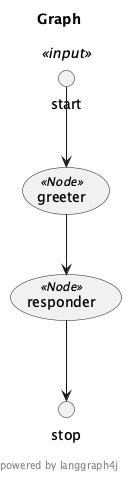

In [10]:
SimpleGraphApp.main(new String[]{});